In [220]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2 as pg

In [221]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [222]:
db_params = {
    "dbname": "sikkaretail_db",
    "user": "psgpyc",
    "password": "",
    "host": "localhost",
    "port": 5432
}

In [223]:
try:
    conn = pg.connect(**db_params)
    curr = conn.cursor()
    print(f"Successfully Connected to the {db_params['dbname']}")
except psycopg2.Error as e:
    print("Error connecting to the database:", e)

Successfully Connected to the sikkaretail_db


## Insights into `customers`

In [224]:
curr.execute("SELECT DISTINCT COUNT(*) FROM customers")
total_customers = curr.fetchone()
total_customers

(4372,)

### There are a total of 4372 unique customers.

---

In [225]:
curr.execute('''
SELECT 
    country,
    COUNT(id) AS total_customers_by_country, 
    ROUND(COUNT(id) * 1.0/ (SELECT COUNT(*) FROM customers)*100, 2)  AS percentage_distribution_by_country
FROM 
    customers
GROUP BY
    country
ORDER BY 
    COUNT(id) DESC;
''')
customers_by_country = pd.DataFrame(curr.fetchall(), columns=['country_name', 'total_customer', '%_of_total'])

In [226]:
customers_by_country.head()

,country_name,total_customer,%_of_total
0,United Kingdom,3949,90.32
1,Germany,95,2.17
2,France,87,1.99
3,Spain,31,0.71
4,Belgium,22,0.50


Text(0.5, 1.0, 'Top 5 Countries by Customers')

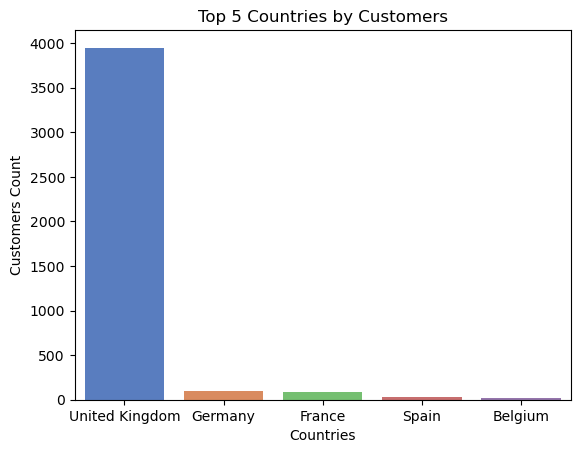

In [229]:
sns.barplot(customers_by_country[customers_by_country['total_customer'] > 20], x='country_name', y='total_customer', palette='muted')
plt.xlabel('Countries')
plt.ylabel('Customers Count')
plt.title('Top 5 Countries by Customers')

### 90% of our customers are from the UK. Other 35 countries contribuiton to the remaining 10%

----

In [63]:
curr.execute('''
SELECT 
    customer_id, 
    COUNT(invoice_no) AS total_order_placed
FROM
    invoices
WHERE 
    customer_id != '00000'
GROUP BY
    customer_id
ORDER BY
    COUNT(invoice_no) DESC;'''
)

In [64]:
total_orders_by_customers = pd.DataFrame(curr.fetchall(), columns = ['customer_id', 'total_orders_placed'])
total_orders_by_customers

,customer_id,total_orders_placed
0,14911.0,248
1,12748.0,223
2,17841.0,169
3,14606.0,128
4,15311.0,118
...,...,...
4366,16349.0,1
4367,13372.0,1
4368,13753.0,1
4369,17359.0,1


In [65]:
total_orders_by_customers.describe()

,total_orders_placed
count,4371.000000
mean,5.075726
std,9.332529
min,1.000000
25%,1.000000
50%,3.000000
75%,5.000000
max,248.000000


#### On average a customer placed 5 orders with a standard deviation of 9.33. The mean is slightly larger than the median, suggesting our dataset is skewed.

-------

### Data Range

In [66]:
curr.execute('''

WITH order_interval AS (
SELECT
	MIN(invoice_date) AS first_order_date,
	MAX(invoice_date) AS last_order_date,
	AGE(MAX(invoice_date), MIN(invoice_date)) AS total_interval
FROM
	invoices)
SELECT
	first_order_date AS from, 
	last_order_date AS to, 
	CONCAT(
		EXTRACT('year' FROM total_interval),
		' years ',
		EXTRACT('days' FROM total_interval),
		' days'
	) AS total_interval
FROM
	order_interval;

''')

In [67]:
pd.DataFrame(curr.fetchall(), columns=['date_of_first_order', 'date_of_last_order', 'interval'])

,date_of_first_order,date_of_last_order,interval
0,2010-12-01 08:26:00,2011-12-09 12:50:00,1 years 8 days


We are evaluating the data of 1 years 8 days.

## Total Orders: Month-over-Month Growth Metrics

In [99]:
curr.execute('''
WITH month_by_month_sales_volume AS (
SELECT
	DATE_TRUNC('months', invoice_date) AS order_months, 
	COUNT(invoice_no) as total_orders
FROM
	invoices
GROUP BY
	DATE_TRUNC('months', invoice_date)),
month_vs_prev_month AS (
SELECT 
	order_months, 
	total_orders AS current_month_total_orders,
	LAG(total_orders) OVER(ORDER BY order_months) AS prev_month_total_orders
FROM
	month_by_month_sales_volume)
SELECT
	TO_CHAR(order_months, 'YYYY-MM'), 
	current_month_total_orders,
	COALESCE(prev_month_total_orders,0) AS prev_month_total_orders,
	ROUND(COALESCE((current_month_total_orders - prev_month_total_orders) * 1.0/(prev_month_total_orders),0),2) AS per_growth
FROM
	month_vs_prev_month;

''')

month_by_month_orders = pd.DataFrame(curr.fetchall(), columns=['month', 'current_month_orders', 'prev_month_orders', 'percentage_growth'])

In [100]:
month_by_month_orders

,month,current_month_orders,prev_month_orders,percentage_growth
0,2010-12,1955,0,0.00
1,2011-01,1442,1955,-0.26
2,2011-02,1367,1442,-0.05
3,2011-03,1906,1367,0.39
4,2011-04,1672,1906,-0.12
5,2011-05,2112,1672,0.26
6,2011-06,1969,2112,-0.07
7,2011-07,1862,1969,-0.05
8,2011-08,1689,1862,-0.09
9,2011-09,2268,1689,0.34


Text(0.5, 1.0, 'Total Orders: Current Month vs. Previous Month')

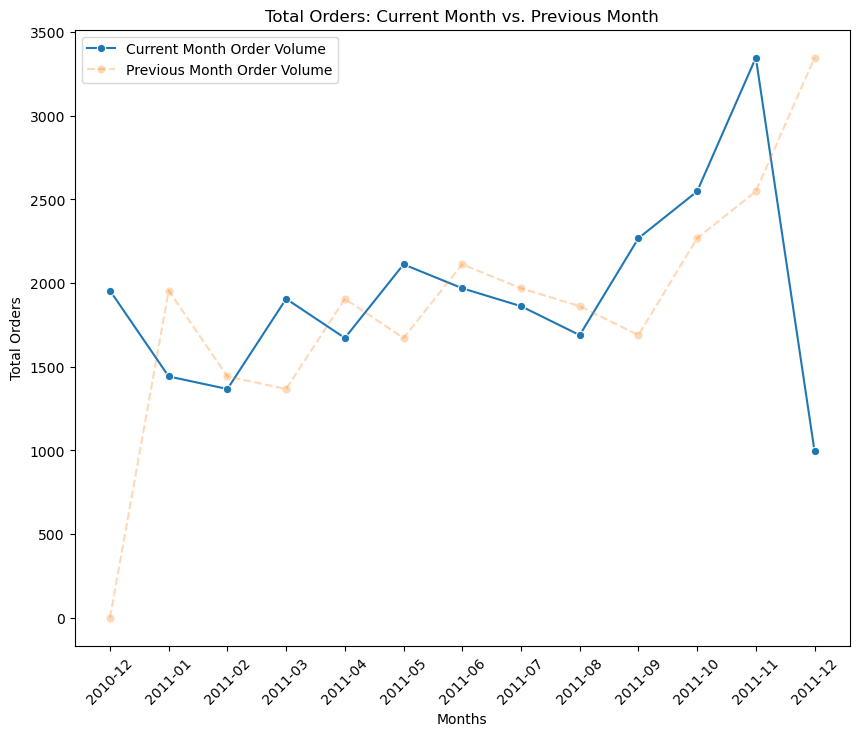

In [101]:
fig, ax = plt.subplots(1,1, figsize=(10,8))

sns.lineplot(month_by_month_orders, x='month', y='current_month_orders', label='Current Month Order Volume', marker='o' )
sns.lineplot(month_by_month_orders, x='month', y='prev_month_orders', label='Previous Month Order Volume', marker='o',linestyle='dashed', alpha=0.3)
ax.set_xlabel('Months')
ax.set_ylabel('Total Orders')
ax.set_xticks(month_by_month_orders['month'])
ax.set_xticklabels(labels=month_by_month_orders['month'], rotation=45)  # Rotate x-axis labels

ax.set_title('Total Orders: Current Month vs. Previous Month')

# Month-over-Month Order Growth Insights

The month-over-month order growth data reveals several key trends:

- **Initial Decline:**  
  - From December 2010 (1955 orders) to January 2011 (1442 orders), there was a sharp decline (-26%), followed by a smaller decline in February (-5%).  
  - This early drop could indicate seasonality or post-holiday adjustments.

- **Rebound in March:**  
  - Orders rebounded strongly in March 2011 (1906 orders), marking a 39% increase over February.  
  - This suggests that customer activity picked up after the initial decline.

- **Fluctuating Performance Mid-Year:**  
  - April 2011 saw a moderate decrease (-12%), followed by a recovery in May with a 26% increase, and minor fluctuations in June (-7%) and July (-5%).  
  - These variations may reflect normal month-to-month variability or short-term market dynamics.

- **Strong Growth in September to November:**  
  - September 2011 experienced a 34% increase, October saw a further increase of 12%, and November 2011 peaked with a 31% increase, indicating a robust period of growth.
  
- **Drastic Drop in December 2011:**  
  - December 2011 orders dropped sharply to 995, a -70% change from November.  
  - This extreme decline is because we clipped our dataset on 2011-12-09

## Total Orders: Month-over-Month Cancelled Metrics

In [102]:
curr.execute(
'''
SELECT
	ROUND(COUNT(invoice_no) * 1.0 / (SELECT COUNT(*) FROM invoices) * 100, 2) AS total_cancelled_orders
FROM
	invoices
WHERE
	is_cancelled = TRUE
''')

In [103]:
curr.fetchall()

[(Decimal('20.58'),)]

### 20.58% of total orders were cancelled.

Let us look into month over month by cancelled orders

In [124]:
curr.execute('''

WITH month_by_month_sales_volume AS (
SELECT
	DATE_TRUNC('months', invoice_date) AS order_months, 
	COUNT(invoice_no) as total_orders
FROM
	invoices
GROUP BY
	DATE_TRUNC('months', invoice_date)), 
month_by_month_cancelled_volume AS (
SELECT
	DATE_TRUNC('months', invoice_date) AS order_months, 
	COUNT(invoice_no) as total_cancelled
FROM
	invoices i
WHERE 
	is_cancelled = TRUE
GROUP BY
	DATE_TRUNC('months', invoice_date))
SELECT 
	TO_CHAR(mmcv.order_months, 'YYYY-MM') AS months, 
	mmsv.total_orders AS total_order_received,
	mmcv.total_cancelled AS total_cancelled,
	ROUND(((mmcv.total_cancelled * 1.0) / (total_orders))*100, 2) AS per_cancelled
	
FROM 
	month_by_month_cancelled_volume mmcv
FULL OUTER JOIN
	month_by_month_sales_volume mmsv
ON mmcv.order_months = mmsv.order_months
ORDER BY mmcv.order_months 

''')

In [125]:
total_orders_vs_cancelled_orders  = pd.DataFrame(curr.fetchall(), columns=['Order Month', 'Total Orders', 'Cancelled Orders', '% cancellation rate'])

In [126]:
total_orders_vs_cancelled_orders

,Order Month,Total Orders,Cancelled Orders,% cancellation rate
0,2010-12,1955,396,20.26
1,2011-01,1442,356,24.69
2,2011-02,1367,267,19.53
3,2011-03,1906,452,23.71
4,2011-04,1672,426,25.48
5,2011-05,2112,431,20.41
6,2011-06,1969,436,22.14
7,2011-07,1862,387,20.78
8,2011-08,1689,328,19.42
9,2011-09,2268,431,19.00


In [137]:
total_orders_vs_cancelled_orders_melted =total_orders_vs_cancelled_orders.melt(id_vars=["Order Month"], value_vars=["Total Orders", "Cancelled Orders"], 
                     var_name="order_group", value_name="order_value")

Text(0.5, 1.0, 'Total Orders vs. Cancelled Orders')

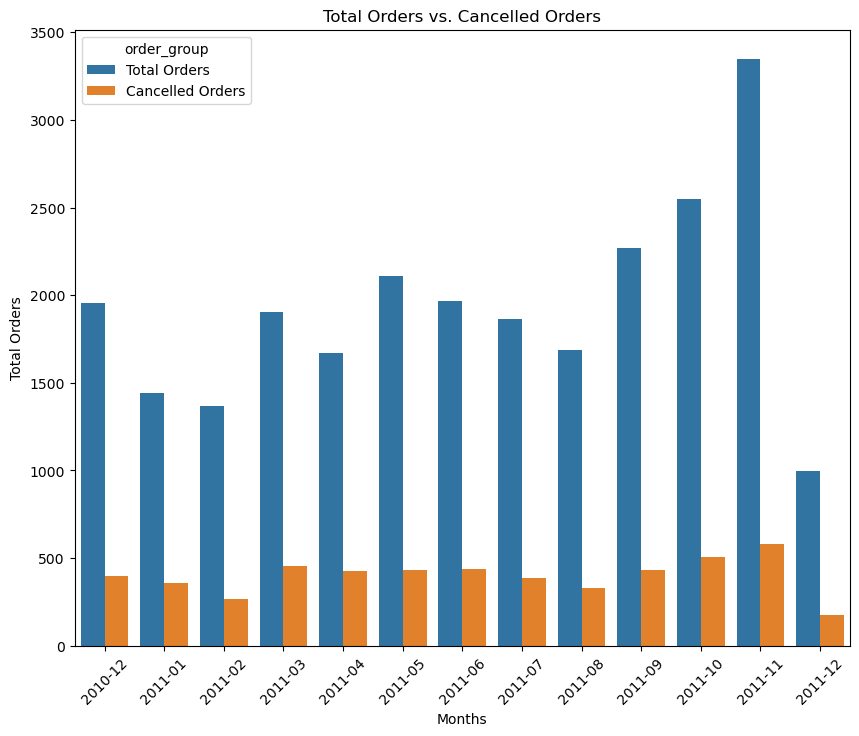

In [141]:
fig, ax = plt.subplots(1,1, figsize=(10,8))
sns.barplot(total_orders_vs_cancelled_orders_melted, x='Order Month', y='order_value', hue='order_group')

ax.set_xlabel('Months')
ax.set_ylabel('Total Orders')
ax.set_xticks(total_orders_vs_cancelled_orders['Order Month'])
ax.set_xticklabels(labels=total_orders_vs_cancelled_orders['Order Month'], rotation=45)  # Rotate x-axis labels

ax.set_title('Total Orders vs. Cancelled Orders')


1. **Overall Cancellation Trends:**
   - The cancellation rate varies month-to-month, ranging from a high of **25.48%** (April 2011) to a low of **17.27%** (November 2011).

2. **Seasonal Patterns:**
   - **Early 2011:**  
     - December 2010 started with a 20.26% cancellation rate.  
     - January and March 2011 maintained high cancellation rates (24.69% and 23.71%, respectively), suggesting a potential seasonal or operational issue at the beginning
        of the year.
       
   - **Mid-Year Fluctuations:**  
     - April 2011 stands out with the highest cancellation rate at 25.48%, which could indicate specific issues during this period.
     - May through August 2011 show moderate rates (ranging from ~19.42% to 22.14%).
       
   - **Late 2011 Improvement:**  
     - In November and December 2011, cancellation rates drop significantly to 17.27% and 17.69%, respectively. This suggests improvements in order processing or customer satisfaction toward the end of the year.

3. **Volume Versus Cancellation Rate:**
   - Although November 2011 recorded the highest total orders (3347), it also features one of the lowest cancellation rates (17.27%). This contrast implies that higher order volumes may be associated with better operational efficiency or customer trust during that month.
   - Conversely, April 2011, despite having a lower order volume (1672), experienced the highest cancellation rate, indicating potential issues that could be explored further.

4. **Implications for Business Strategy:**
   - **Investigate High Cancellation Months:**  
     The peak cancellation rate in April suggests a need for deeper investigation into the causes—whether they are due to process inefficiencies, external market conditions, or customer-related factors.
   - **Leverage Low Cancellation Periods:**  
     The lower cancellation rates in November and December can be seen as a benchmark for operational performance and customer satisfaction. These months could be studied further to replicate successful practices in other periods.
   - **Targeted Improvements:**  
     Identifying the underlying reasons for fluctuations can help design targeted interventions to reduce cancellations, improve customer service, and ultimately increase revenue.



## Revenue

In [143]:
curr.execute(
'''
WITH invoice_order_value AS (
SELECT
	invoice_no,
	SUM(quantity * unit_price) AS order_value
FROM
	invoice_items
GROUP BY
	invoice_no
HAVING 
	SUM(quantity * unit_price) > 0 )
SELECT 
	SUM(order_value) AS total_revenue
FROM 
	invoice_order_value
WHERE	
	order_value > 0
''')

In [144]:
curr.fetchone()

(Decimal('10643627.27'),)

**The total revemue is 10,643,627.27 i.e £10.5 Million**

In [158]:
curr.execute('''
WITH invoice_order_value AS (
SELECT
	invoice_no,
	SUM(quantity * unit_price) AS order_value
FROM
	invoice_items
GROUP BY
	invoice_no
HAVING 
	SUM(quantity * unit_price) < 0 )
SELECT 
	ABS(SUM(order_value)) AS lost_revenue
FROM 
	invoice_order_value
WHERE	
	order_value < 0
''')

In [159]:
curr.fetchone()

(Decimal('893979.73'),)

**Total revenue lost due to cancellation is £ 893,939.72**

### Month Over Month Analysis on Revenue

In [193]:
curr.execute(
'''
WITH month_by_month_rev AS (
SELECT
	TO_CHAR(DATE_TRUNC('months', i.invoice_date), 'YYYY-MM-DD') AS curr_month,
	SUM(ii.quantity * ii.unit_price) AS curr_month_rev 
FROM
	invoice_items ii
JOIN
	invoices i
ON
	i.invoice_no = ii.invoice_no
WHERE
	i.is_cancelled = FALSE
GROUP BY
	DATE_TRUNC('months', i.invoice_date)
ORDER BY
	DATE_TRUNC('months', i.invoice_date)),
month_vs_prev_month AS (
SELECT 
	curr_month, 
	curr_month_rev,
	LAG(curr_month_rev) OVER(ORDER BY curr_month) AS prev_month_rev
FROM 
	month_by_month_rev)
SELECT
	curr_month, 
	curr_month_rev, 
	COALESCE(prev_month_rev, 0) AS prev_month_rev,
	COALESCE(ROUND(((curr_month_rev - prev_month_rev)/(prev_month_rev))*100,2), 0) AS rev_growth
FROM
	month_vs_prev_month;

''')

In [194]:
mom_rev = pd.DataFrame(curr.fetchall(), columns=['month', 'current_month_rev', 'prev_month_rev', '%_growth'])

In [195]:
mom_rev

,month,current_month_rev,prev_month_rev,%_growth
0,2010-12-01,821518.86,0,0
1,2011-01-01,689931.41,821518.86,-16.02
2,2011-02-01,522545.56,689931.41,-24.26
3,2011-03-01,716285.13,522545.56,37.08
4,2011-04-01,536981.29,716285.13,-25.03
5,2011-05-01,769685.01,536981.29,43.34
6,2011-06-01,760547.01,769685.01,-1.19
7,2011-07-01,718143.61,760547.01,-5.58
8,2011-08-01,758210.98,718143.61,5.58
9,2011-09-01,1056442.39,758210.98,39.33


Text(0.5, 1.0, 'Total Revenue: Current Month vs. Previous Month')

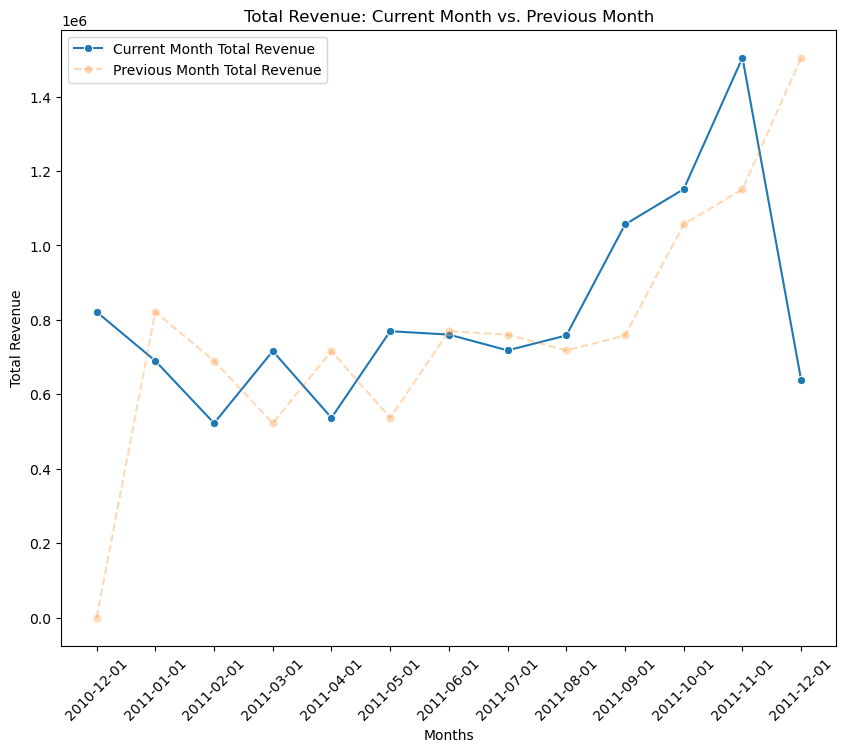

In [196]:
fig, ax = plt.subplots(1,1, figsize=(10,8))    

sns.lineplot(mom_rev, x='month', y='current_month_rev', label='Current Month Total Revenue', marker='o' )
sns.lineplot(mom_rev, x='month', y='prev_month_rev', label='Previous Month Total Revenue', marker='o',linestyle='dashed', alpha=0.3)
ax.set_xlabel('Months')
ax.set_ylabel('Total Revenue')
ax.set_xticks(mom_rev['month'])
ax.set_xticklabels(labels=mom_rev['month'], rotation=45)  # Rotate x-axis labels

ax.set_title('Total Revenue: Current Month vs. Previous Month')

### Month Over Month Revenue Lost

In [188]:
curr.execute(
'''
WITH month_by_month_rev_lost AS (
SELECT
	TO_CHAR(DATE_TRUNC('months', i.invoice_date), 'YYYY-MM-DD') AS curr_month,
	SUM(ii.quantity * ii.unit_price) AS curr_month_rev_lost 
FROM
	invoice_items ii
JOIN
	invoices i
ON
	i.invoice_no = ii.invoice_no
WHERE
	i.is_cancelled = TRUE
GROUP BY
	DATE_TRUNC('months', i.invoice_date)
ORDER BY
	DATE_TRUNC('months', i.invoice_date)),
month_vs_prev_month AS (
SELECT 
	curr_month, 
	curr_month_rev_lost,
	LAG(curr_month_rev_lost) OVER(ORDER BY curr_month) AS prev_month_rev_lost
FROM 
	month_by_month_rev_lost)
SELECT
	curr_month, 
	ABS(curr_month_rev_lost) AS current_month_revenue_lost, 
	COALESCE(ABS(prev_month_rev_lost), 0) AS prev_month_rev_lost,
	COALESCE(ROUND(((ABS(curr_month_rev_lost) - ABS(prev_month_rev_lost))/(ABS(prev_month_rev_lost)))*100,2), 0) AS rev_lost_change
FROM
	month_vs_prev_month;
''')

In [189]:
mom_rev_lost = pd.DataFrame(curr.fetchall(), columns=['month', 'current_month_rev_lost', 'prev_month_rev_lost', '%_growth'])

In [191]:
mom_rev_lost

,month,current_month_rev_lost,prev_month_rev_lost,%_growth
0,2010-12-01,74729.12,0,0
1,2011-01-01,131363.05,74729.12,75.79
2,2011-02-01,25519.15,131363.05,-80.57
3,2011-03-01,34201.28,25519.15,34.02
4,2011-04-01,44600.65,34201.28,30.41
5,2011-05-01,47202.51,44600.65,5.83
6,2011-06-01,70569.78,47202.51,49.50
7,2011-07-01,37919.13,70569.78,-46.27
8,2011-08-01,54330.80,37919.13,43.28
9,2011-09-01,38838.51,54330.80,-28.51


In [202]:
rev_df = pd.concat([mom_rev['month'],mom_rev['current_month_rev'], mom_rev_lost['current_month_rev_lost']], axis=1)

In [203]:
rev_df

,month,current_month_rev,current_month_rev_lost
0,2010-12-01,821518.86,74729.12
1,2011-01-01,689931.41,131363.05
2,2011-02-01,522545.56,25519.15
3,2011-03-01,716285.13,34201.28
4,2011-04-01,536981.29,44600.65
5,2011-05-01,769685.01,47202.51
6,2011-06-01,760547.01,70569.78
7,2011-07-01,718143.61,37919.13
8,2011-08-01,758210.98,54330.80
9,2011-09-01,1056442.39,38838.51


Text(0.5, 1.0, 'Total Revenue vs. Lost Revenue: by months ')

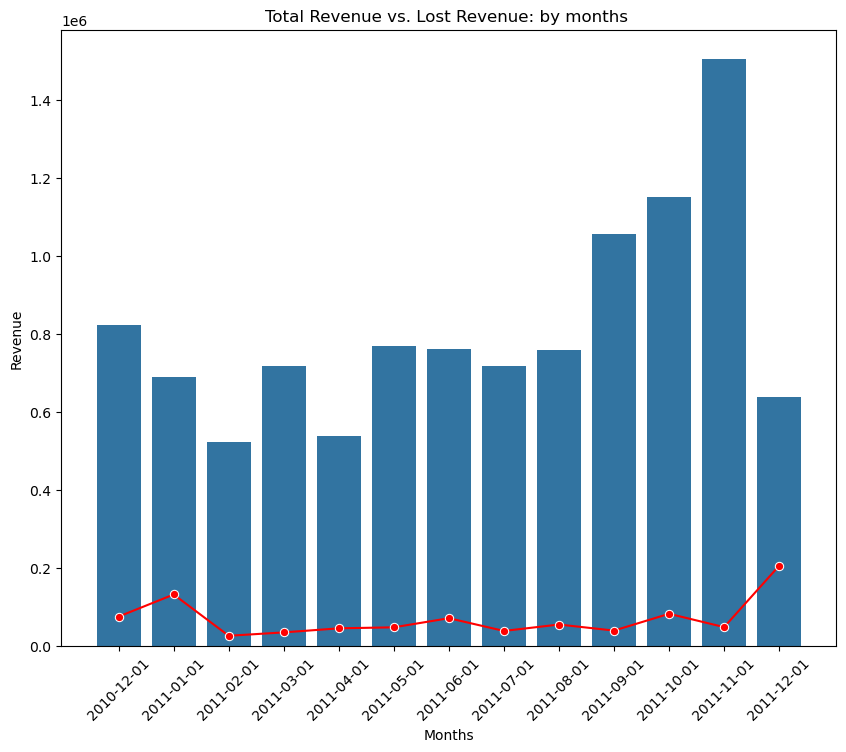

In [211]:
fig, ax = plt.subplots(1,1, figsize=(10,8))

sns.barplot(rev_df, x='month', y='current_month_rev')
sns.lineplot(rev_df, x='month', y='current_month_rev_lost', marker='o', color='red')


ax.set_xlabel('Months')
ax.set_ylabel('Revenue')
ax.set_xticks(rev_df['month'])
ax.set_xticklabels(labels=rev_df['month'], rotation=45)  # Rotate x-axis labels

ax.set_title('Total Revenue vs. Lost Revenue: by months ')

- **Investigate Anomalies:**  
  - The drastic decline in revenue and spike in lost revenue in December 2011 merit further investigation. Understanding the underlying causes—be it seasonal effects, promotional issues, or operational challenges—could help mitigate similar occurrences in the future.

- **Optimize Cancellation Processes:**  
  - Since lost revenue is relatively low in most months but peaks in specific periods, focusing on strategies to reduce cancellations during high-risk months (like January and December) could enhance overall profitability.
